# Homework 2 - eCommerce analytics
--------

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('~/Desktop/Datasets/2019-Oct.csv', nrows = 1000000)

# Qua dobbiamo caricare tutti i files e unirli, per ora metto solo questo

# [RQ1] Customer’s journey 

-------------

### What’s the operation users repeat more on average within a session?

In [4]:
# Finding types of events

df['event_type'].unique()

array(['view', 'purchase', 'cart'], dtype=object)

In [5]:
event_series = df.groupby('event_type').event_type.count().to_frame('number_of_events').reset_index()
event_series

,event_type,number_of_events
0,cart,14639
1,purchase,16848
2,view,968513


In [6]:
n = df['user_session'].nunique()
event_series['avg_events'] = event_series.apply(lambda row: row.number_of_events /n, axis=1)
event_series

,event_type,number_of_events,avg_events
0,cart,14639,0.064667
1,purchase,16848,0.074426
2,view,968513,4.278376


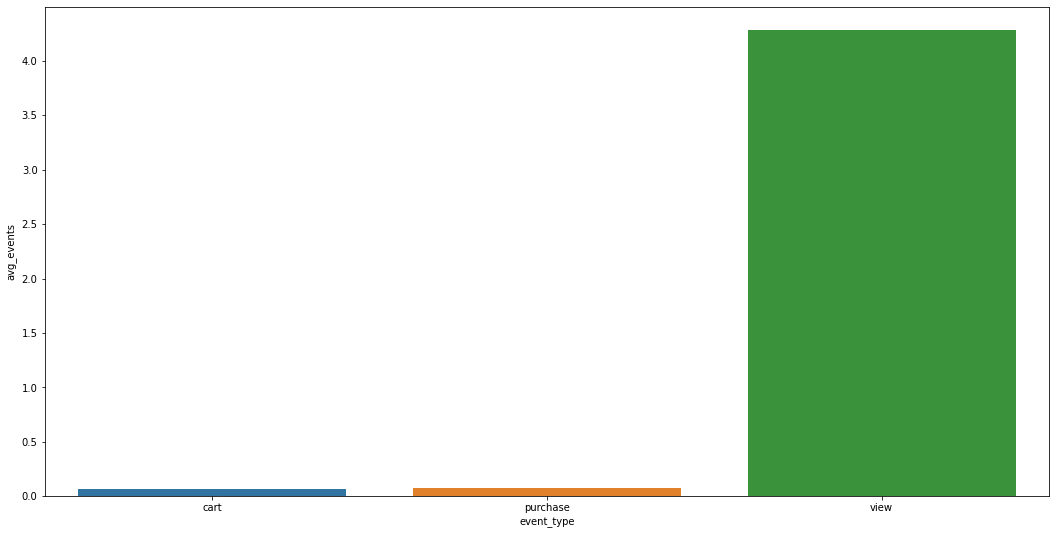

In [7]:
fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='event_type', y='avg_events', data=event_series)

As we could have expected, the views are by far the most repeated operation. We think that is because, in order to perform a cart or purchase operation a customer might has inevitably view the product.

### How many times, on average, a user views a product before adding it to the cart?

This analysis could have been performed in two ways: by computing the average number of views before every effectively bought article or, as we did, by computing the ratio between the number of `view` and the number of `cart` events. We think that including products that aren't bought provides us a more truthful insight on the number of views that are needed before we have a `cart` event. 

In [8]:
nviews = int(event_series[event_series.event_type == 'view']['number_of_events'])
ncarts = int(event_series[event_series.event_type == 'cart']['number_of_events'])
print('On average, products are seen', round(nviews/ncarts,3),'times before they are added to the cart.')

On average, products are seen 66.16 times before they are added to the cart.


### What’s the probability that products added once to the cart are effectively bought?

We make the same assumptions as before, so we compute an average probability.

In [9]:
npurchases = int(event_series[event_series.event_type == 'purchase']['number_of_events'])
print('The probability is estimated as:', round(npurchases/ncarts,4))

The probability is estimated as: 1.1509


### What’s the average time an item stays in the cart before being removed?

### How much time passes on average between the first view time and a purchase/addition to cart?

# [RQ2] Sold products per category

---------

# [RQ3] Categories prices

-------

# [RQ4] How much does each brand earn per month?

------

# [RQ5] Hourly average visitors 

-------

# [RQ6] Conversion rate

--------

### Find the overall conversion rate of your store.¶


In this task we search for the overall conversion rate of the store i.e. the number of times a product has been bought over the number of times it has been visited.

In [10]:
# Creating subsets

views = df[df.event_type == 'view']
purchases = df[df.event_type == 'purchase']

In [11]:
# Conversion rate = number of purchases / number of views

conversion_rate = purchases['product_id'].count() / views['product_id'].count()
print('The overall conversion rate is:', round(conversion_rate,3))

The overall conversion rate is: 0.017


### Plot the number of purchases of each category

In order to explore categories, we can look at the `category_id` or the `category_code` columns. We decided to use the second one because, even though it has a cosiderable amount of `NaN` values, it is more illustrative and meaningful to plot (there are less unique values). In fact we can look at the first level of each category (e.g. in `accessories.bag` we only need `accessories`).

In [12]:
# Exploring categories

df['category_code'].unique()[:5]

array([nan, 'appliances.environment.water_heater',
       'furniture.living_room.sofa', 'computers.notebook',
       'electronics.smartphone'], dtype=object)

In [13]:
df['category_id'].nunique()

546

In [14]:
# Extracting first level categories 

def fun(x):
    return str(x).split('.')[0]

df["category"]=df["category_code"].apply(fun)

In [15]:
#Check

df['category'].unique()[:5]

array(['nan', 'appliances', 'furniture', 'computers', 'electronics'],
      dtype=object)

In [16]:
# Now we create again the subsets to include the new column ONLY NOT NAN

df_notNan = df[df.category != 'nan']
views_notNan = df_notNan[df_notNan.event_type == 'view']
purchases_notNan = df_notNan[df_notNan.event_type == 'purchase']

In [17]:
d1 = purchases_notNan.groupby('category').event_type.count().reset_index().rename(columns =
                                         {'event_type':'purchases_number'})
d1.head(3)

,category,purchases_number
0,accessories,40
1,apparel,130
2,appliances,1757


In [18]:
# Finding number of views for each category

d2 = views_notNan.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'views_number'})

In [19]:
# Joining dataframes in order to have the number of purchases and views for each category

dout = d1.merge(d2, on = 'category')
dout.head(3)

,category,purchases_number,views_number
0,accessories,40,5621
1,apparel,130,29594
2,appliances,1757,113360


In [20]:
# Adding a third column that is a combination of the other two in order to find the c.r.

dout['conversion_rate'] = dout.apply(lambda row: 
                                     row.purchases_number / row.views_number, axis=1)

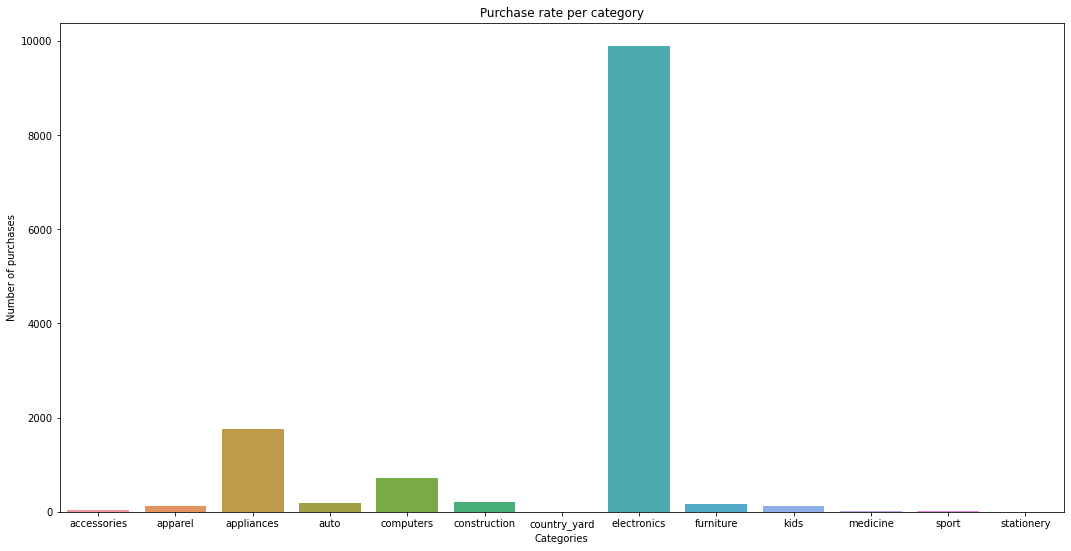

In [21]:
fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='category', y='purchases_number', data=dout)
plot.set(xlabel='Categories', ylabel='Number of purchases', title = 'Purchase rate per category')
plt.show()

The `electronics` category seems to be one with the bigger number of purchases by a lot while `medicine`,`country-yard` and `stationery` the less bought.

### Show the conversion rate of each category in decreasing order

In [22]:
# Sorting values

dout.sort_values(by='conversion_rate', ascending = False)

,category,purchases_number,views_number,conversion_rate
7,electronics,9890,363833,0.027183
10,medicine,10,388,0.025773
12,stationery,4,157,0.025478
2,appliances,1757,113360,0.015499
4,computers,715,56160,0.012731
5,construction,206,18687,0.011024
9,kids,127,12109,0.010488
3,auto,192,24135,0.007955
6,country_yard,4,559,0.007156
0,accessories,40,5621,0.007116


Despite `medicine` and `stationery` have a relatively little number of purchases, they have a fairly high conversion rate. 


INSERT METHOD 2

# [RQ7] The Pareto principle¶


---------------

### Prove that the Pareto principle applies to your store.

We want to prove the Pareto principle by contructing a column that computes the cumulative percetage sum of the revenue for each user and finding the one that corresponds to the 80% of the store revenue. 

In [26]:
# Grouping customers and computing total revenue (amount of money spent) for each one 

customers = df.groupby('user_id').price.sum().to_frame('total_revenue').sort_values(
    by='total_revenue', ascending = False).reset_index()
customers.head(3)

,user_id,total_revenue
0,513611029,180017.61
1,536093085,159877.24
2,522345808,147603.82


In [27]:
# Adding column with cumulative sum : cumul_sum[i] = cumul_sum[i-i] 

revenue = customers['total_revenue'].sum()
customers['cumul_sum'] = customers['total_revenue'].cumsum()
customers.head(3)

,user_id,total_revenue,cumul_sum
0,513611029,180017.61,180017.61
1,536093085,159877.24,339894.85
2,522345808,147603.82,487498.67


In [28]:
# Adding column with the percentage of the cumulative sum over the store revenue 

customers['percent_cumul_sum'] = customers.apply(lambda row: 
                                     round(row.cumul_sum / revenue,4)*100, axis=1)
customers.head(3)

,user_id,total_revenue,cumul_sum,percent_cumul_sum
0,513611029,180017.61,180017.61,0.06
1,536093085,159877.24,339894.85,0.11
2,522345808,147603.82,487498.67,0.16


In [29]:
pareto_index = customers[customers['percent_cumul_sum'] >= 80].index[0]
print('The', round((pareto_index/len(customers))*100,3),'percent of the users provides approximately the 80 percent of the store revenue.')

The 28.23 percent of the users provides approximately the 80 percent of the store revenue.


The *Pareto index* in the graphic below refers to the percentage of customers that provides the 80% of the store revenue.

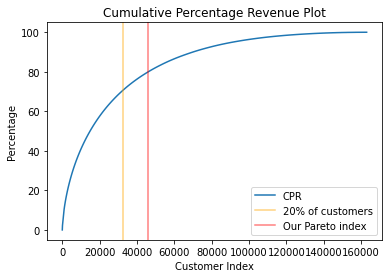

In [30]:
customers['percent_cumul_sum'].plot(label='CPR')
plt.figsize = (25,7)
plt.title('Cumulative Percentage Revenue Plot')
plt.ylabel('Percentage')
plt.xlabel('Customer Index')
plt.axvline(0.2*len(customers), label='20% of customers',color='orange',alpha=0.5)
plt.axvline(pareto_index, label='Our Pareto index',color='red',alpha=0.5)
plt.legend()

plt.show()

By looking at the distance between the yellow and the red line, we can affirm that the Pareto principle approximatively applies on our online store. 